In [54]:
from src.sklearn_pipeline import *
from src.models import *

# import numpy as np

### Load and Clean Chyron Data

* Data has already been pulled from https://archive.org/services/third-eye.php via its API. 
* For a script to pull the data, convert it to a dataframe, and save locally as a .csv, see `src/get_chyrons.py`

In [55]:
# load and clean data, convert to dataframe
chy_summer = load_summer()

# filter dataframe for MSNBC and Fox News, then vectorize 
chy_nets = get_network_pair(chy_summer, net_one='FOXNEWSW', net_two='MSNBCW')
feature_count, count_vec = clean_counts(chy_nets, n_grams=(1,2))

# get network-based dataframes for eda
fox_features, fox_counts = clean_counts(chy_nets.loc[chy_nets['channel'] == 'FOXNEWSW'], n_grams=(1,2))
msnbc_features, msnbc_counts = clean_counts(chy_nets.loc[chy_nets['channel'] == 'MSNBCW'], n_grams=(1,2))
fox_df = get_dataframe(fox_counts, fox_features)
msnbc_df = get_dataframe(msnbc_counts, msnbc_features)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['age', 'angi', 'anon', 'associated', 'biden', 'bravest', 'campaign', 'cases', 'com', 'covid', 'covld', 'death', 'deaths', 'election', 'floyd', 'id', 'ilem', 'ill', 'july', 'li', 'lin', 'mo', 'mssnbc', 'news', 'pandemic', 'prfslnfntiai', 'race', 'relief', 'response', 'trump', 'vaccine'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['angi', 'anon', 'biden', 'bravest', 'campaign', 'cases', 'com', 'covid', 'covld', 'democracy', 'devi', 'donate', 'election', 'ft', 'hands', 'ia', 'id', 'ill', 'inn', 'li', 'lia', 'lin', 'mo', 'month', 'mssnbc', 'nearly', 'news', 'nnlrl'

### EDA

* Calculating word frequencies
* Charting major differences between in word frequency between networks
* Charting shared word counts

In [56]:
# get word frequency by network, calculate difference in frerquencies, and sort descending
df = freq_df(fox_df, msnbc_df)
df.head()

,word,fox_freq,msnbc_freq,difference
1279,trump,11.981660,20.695913,8.714253
1354,virus,0.290058,3.092238,2.802181
179,cases,0.610039,3.356580,2.746542
938,president trump,3.138514,0.554181,2.584333
937,president,4.137548,1.674541,2.463008


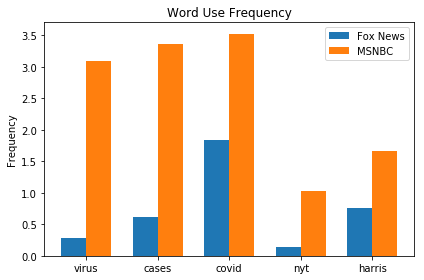

In [57]:
# charting significant differences in word frequency:
# words used more frequently by MSNBC
chart_word_diff(df,['virus', 'cases', 'covid', 'nyt', 'harris'])

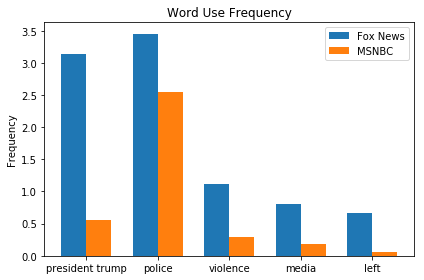

In [58]:
# words used more frequently by Fox News
chart_word_diff(df,['president trump', 'police', 'violence', 'media', 'left'])

In [59]:
# getting word counts for charting similarities
word_counts = get_dataframe(count_vec, feature_count)
word_counts['network'] = chy_nets['channel']
word_counts = word_counts.assign(network=chy_nets['channel'].values)
fox_words = word_counts.loc[word_counts['network'] == 'FOXNEWSW']
nbc_words = word_counts.loc[word_counts['network'] == 'MSNBCW']

# sum of top Fox words
fox_words.drop('network', axis=1, inplace=True)
top_fox_words = fox_words.sum().sort_values(ascending=False)
fox_word_counts = fox_words.sum()

# sum of top MSNBC words
nbc_words.drop('network', axis=1, inplace=True)
top_nbc_words = nbc_words.sum().sort_values(ascending=False)
nbc_word_counts = nbc_words.sum()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [65]:
def chart_shared_word_counts(nbc_word_counts, fox_word_counts, thresh=20000):
    fig, ax = plt.subplots()
    nbc_lt = []
    fox_lt = []
    words = []
    
    for i, word in enumerate(nbc_word_counts):
        if word < thresh:
            nbc_lt.append(nbc_word_counts[i])
            fox_lt.append(fox_word_counts[i])
        
    ax.scatter(nbc_lt, fox_lt, alpha=0.3)
    ax.set_title('Shared Word Counts by Network')
    ax.set_xlabel('MSNBC')
    ax.set_ylabel('Fox News');

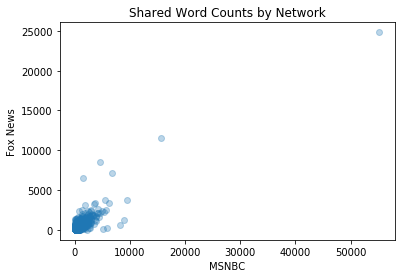

In [66]:
chart_shared_word_counts(nbc_word_counts, fox_word_counts, thresh=60000)

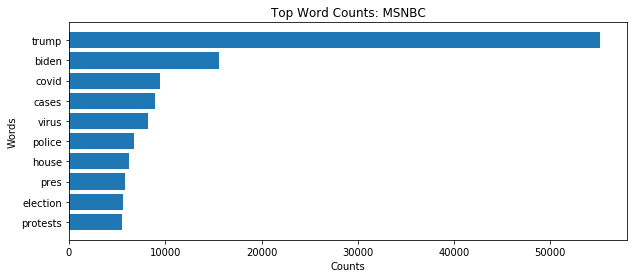

In [67]:
# top words bar graph, MSNBC
chart_top(top_nbc_words, 'MSNBC', low=0, high=10)

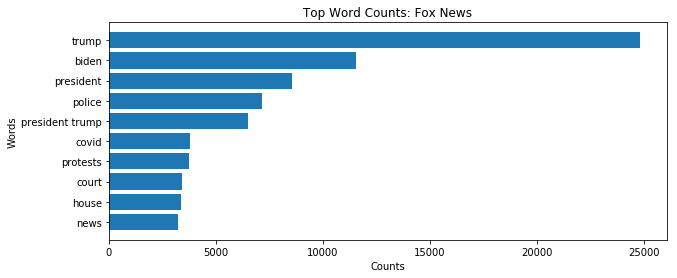

In [68]:
# top words bar graph, Fox News
chart_top(top_fox_words, 'Fox News', low=0, high=10)

### Modeling 

* Set up X and y for train, test, split 
* Evaluate Naive Bayes and Random Forest models
* Plot ROC curve, confusion matrix, and gini importance

In [69]:
# X, y
X_counts = get_dataframe(count_vec, feature_count)
y = chy_nets['channel']

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, 
                                                    train_size=0.33, 
                                                    shuffle=True, stratify=y)

##### Naive Bayes:

In [71]:
# Naive Bayes
import numpy as np 

def eval_naive_bayes(X, y, folds=20, fit_prior=False):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    
    for train, test in kf.split(X):
        model = MultinomialNB(alpha=1, fit_prior=fit_prior)
        model.fit(X.iloc[train], y.iloc[train])
        accuracy.append(model.score(X.iloc[test], y.iloc[test]))
    
    return model, np.mean(accuracy)

In [72]:
# fit Naive Bayes and evaluate accuracy
bayes, accuracy = eval_naive_bayes(X_test, y_test, folds=20)
print(accuracy)

0.7700307683188244


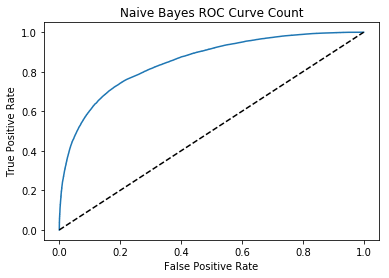

In [73]:
# plot ROC curve
plot_roc(X_test, y_test);

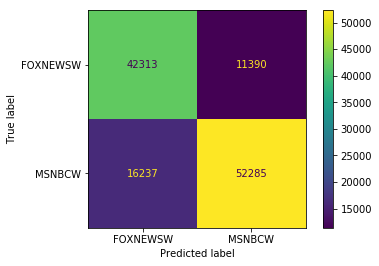

In [74]:
# plot confustion matrix
plot_confusion_matrix(bayes, X_test, y_test)  
plt.show()

In [77]:
# sorting model probabilites to pull related chyrons 
import pandas as pd

def sort_probs(model, X, y):
    y_net = [1 if net == 'MSNBCW' else 0 for net in y]
    probs = model.predict_proba(X)
    df = pd.DataFrame(probs)
    df['net'] = y_net
    df['index'] = X.index
    msnbc = df.loc[df['net'] == 1]
    fox = df.loc[df['net'] == 0]

    return msnbc, fox

def sort_chyrons(msnbc, fox):
    sorted_ms = []
    sorted_fox = []
    ms_sort = msnbc.sort_values(by=1)
    fox_sort = fox.sort_values(by=1)

    for i in ms_sort['index']:
        sorted_ms.append(chy_summer.iloc[i, 6])

    for i in fox_sort['index']:
        sorted_fox.append(chy_summer.iloc[i, 6])
    
    return sorted_fox, sorted_ms

In [78]:
# pull for each chyrons sorted by model generated probability
msnbc, fox = sort_probs(bayes, X_train, y_train)
fox_chys, ms_chys = sort_chyrons(msnbc, fox)

In [79]:
# top 5 Fox chyrons
fox_chys[:5]

["WEST POINT GRADUATE REACTS TO TRUMP'S MESSAGE TRUMP ADDRESSES GRADUATES AT WEST POINT",
 'AMB. EISEN ON HIS NEW BOOK,  201cA CASE FOR THE AMERICAN. PEOPLE: THE UNITED STATES V. DONALD J. TRUMP\\" AG BARR SPARS WITH DEM LAWMAKERS IN CONTENTIOUS HEARING',
 "LIHLL I'OUU'OO I'OOOC 'emc PureWick. . :Lern. . . . Urlne",
 "HOW THE LEFT DISCARDED SCIENCE FOR POWER '1. x e . , .m DR HARVEY RISCH. YALE PROFESSOR OF EPIDEMIOLOGY. WEDNESDAY",
 'CALIFORNIA TO STOP ALL INDOOR BUSINESSES FOR THREE WEEKS U.S. ADDS 4.8M JOBS IN JUNE, UNEMPLOYMENT DROPS TO 11.1%']

In [80]:
# top 5 MSNBC chyrons 
ms_chys[:5]

['NATIONAL GUARD AND PROTESTERS FACE OFF IN WASHINGTON',
 'NEW PROTESTS AS ALL 4 OFFICERS ARE CHARGED IN FLOYD DEATH KAREEM ABDUL-JABBAR ON PROTESTS, DEATH OF GEORGE FLOYD',
 'TOP U.S. GENERAL: APPEARING IN TRUMP BIBLE PHOTO-OP A \\"MISTAKE\\" TRUMP TO REQUIRE RALLY ATTENDEES TO SIGN CORONAVIRUS WAIVER',
 'WIDESPREAD LOOTING AND UNREST IN NYC',
 'WHERE\' 5 THE BEEF?. NEARLY 43r ooo POUNDS OE RAW MEAT RECALLED. . Frrm 2019 \\"fr HL_ _']

##### Random Forest

In [83]:
def eval_random_forest(X, y, folds=10, n_estimators=100, max_depth=5, max_leaf=None, max_features='log2'):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    oob = []
    iters = 0
    
    for train, test in kf.split(X):
        forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, n_jobs=-1, 
                                        max_leaf_nodes=max_leaf, max_features=max_features, 
                                        oob_score=True)
        forest.fit(X.iloc[train], y.iloc[train])
        accuracy.append(forest.score(X.iloc[test], y.iloc[test]))
        oob.append(forest.oob_score_)
        
        print(iters)
        iters += 1
    
    return np.mean(accuracy), np.mean(oob), forest

In [84]:
# fit Random Forest and evaluate accuracy
accuracy, oob, forest = eval_random_forest(X_train, y_train, folds=10, n_estimators=100, max_depth=100)
print(f'Accuracy = {accuracy}, OOB = {oob}')

0
1
2
3
4
5
6
7
8
9
Accuracy = 0.8093323881904423, OOB = 0.8039779168843614


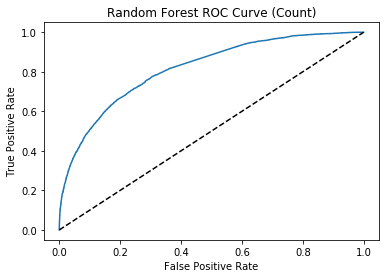

In [86]:
# plot ROC curve
plot_roc_forest(X_train, y_train, vec_type='(Count)');

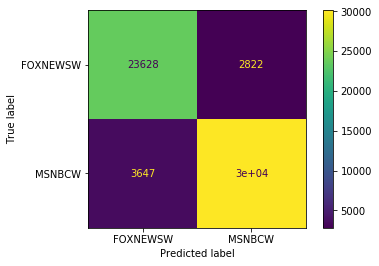

In [85]:
# plot confusion matrix
plot_confusion_matrix(forest, X_train, y_train)  
plt.show()

In [88]:
def chart_gini_import(model, X, size=15):
    fig, ax = plt.subplots()
    feature_scores = pd.Series(model.feature_importances_, index=X.columns)
    feature_scores = feature_scores.sort_values()
    ax = feature_scores[:15].plot(kind='barh', figsize=(10,4))
    ax.set_title('Gini Importance')
    ax.set_xlabel('Avg. Contribution to Info Gain');

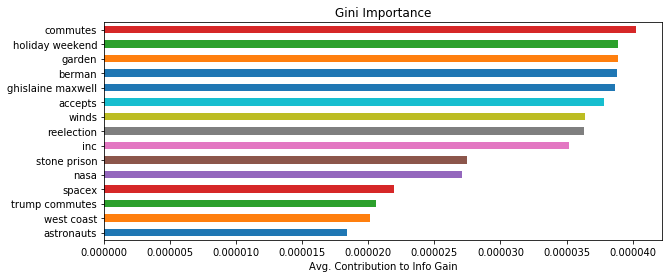

In [89]:
# chart gini importance
chart_gini_import(forest, X_train)